# Protein Structure Prediction with the AlphaFold2 NIM
This example notebook demonstrates how deploy the NVIDIA AlphaFold2 NIM for predicting the 3D structure of a protein from its amino acid sequence.

NVIDIA BioNeMo NIMS can be integrated into existing virtual screening workflows to leverage cutting edge Gen-AI capabilities for drug discovery, from ligand generation to protein folding to docking. For more details, please visit the [NVIDIA BioNeMo NIMS homepage](https://build.nvidia.com/explore/healthcare).

These capabilities are also integrated into reference workflows in NVIDIA NIM Agent Blueprints. For more details, please visit [NVIDIA NIM Blueprints](https://build.nvidia.com/nim/blueprints).


## Setup
Please make sure the required packages and dependencies are installed. You may install the required packages using the following `pip install` command.

In [ ]:
# Please run the following 'pip install' command to install the required libraries
!pip install py3dmol

import requests

# Import libraries for 3-D visualization
import py3Dmol
import ipywidgets as widgets
from IPython.display import display

## Prepare the AlphaFold2 NIM
Please visit the [NVIDIA AlphaFold2 NIM page](https://build.nvidia.com/deepmind/alphafold2) for additional details and the [AlphaFold NIM Documentation](https://docs.nvidia.com/nim/bionemo/alphafold2/latest/overview.html) to get started.

The following basic steps should be run on the system hosting the AlphaFold2 NIM.

1. Set your NGC API Key: `export NGC_CLI_API_KEY=<PASTE_API_KEY_HERE>`
2. Run `docker login --username '$oauthtoken' --password $NGC_CLI_API_KEY`
3. Run the container:
   ```bash
      export LOCAL_NIM_CACHE=~/.cache/nim
      docker run --rm --name alphafold2 --runtime=nvidia \
        -e NGC_CLI_API_KEY \
        -v $LOCAL_NIM_CACHE:/opt/nim/.cache \
        -p 8000:8000 \
        nvcr.io/nim/deepmind/alphafold2:1.0.0
    ```

> **NOTE:**  It is especially important to define your `LOCAL_NIM_CACHE` to store the models and databases used by the AlphaFold2 NIM.  These downloads are approximately 500GB and can require hours to download depending on your internet connection.  Using the `LOCAL_NIM_CACHE` will avoid having to re-download these files on subsequent runs.

You can verify that the NIM has started successfully by querying its status.  The following command will return `{"status":"ready"}` when the NIM is ready:
```bash
   curl -X 'GET' \
     'http://localhost:8000/v1/health/ready' \
     -H 'accept: application/json'
```

Once the AlphaFold2 NIM has started, you can define the AF2_NIM_HOST variable for use in the code blocks below.  We assume the NIM is running locally.  Please update the URL or IP for your NIM deployment.

In [2]:
AF2_NIM_HOST = 'http://localhost:8000'

## Protein Folding with AlphaFold2
Once a protein target of interest has been identified, the first step of a virtual screening demonstration is to generate a plausible structure of that protein. We can do this AlphaFold2, a generative, transformer-based model that translates protein sequences into protein structures.

To demonstrate this part of a virtual screening workflow, we begin with an example protein. Here, we choose the SARS-CoV-2 main protease as our starting sequence. We query the AlphaFold2 endpoint with this sequence and the model returns the predicted protein structure.

Please note that this step may take 15~20 minutes to be finished (depending on the GPU type).

In [3]:
# SARS CoV-2 main protease sequence
protein = "SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTFQ"

In [4]:
# Query AlphaFold2 with sequence above
af2_response = requests.post(
    f'{AF2_NIM_HOST}/protein-structure/alphafold2/predict-structure-from-sequence',
    json={
        'sequence': protein,
        'databases': ['uniref90', 'mgnify', 'small_bfd'],
        'msa_algorithm': 'jackhmmer',
        'e_value': 0.0001,
        'bit_score': -1, # -1 means to fallback to the e-value
        'msa_iterations': 1,
        'relax_prediction': True,
    }).json()

In [5]:
# Receive protein structure for SARS CoV-2 protease
folded_protein = af2_response[0]

In [6]:
# [OPTIONAL STEP]: Write the structure coordinates to a file
filename = "folded_protein.pdb"

# Open the file in write mode
with open(filename, 'w') as file:
    # Write some text to the file
    file.write(folded_protein)

In [7]:
# Printing a subset of atomic 3-D coordinates from the AlphaFold-2 predicted structure
print(folded_protein[:483])

ATOM      1  N   SER A   1     -16.248 -16.112  12.945  1.00 69.93           N  
ATOM      2  H   SER A   1     -15.577 -16.770  13.315  1.00 69.93           H  
ATOM      3  H2  SER A   1     -16.451 -15.432  13.665  1.00 69.93           H  
ATOM      4  H3  SER A   1     -17.108 -16.567  12.677  1.00 69.93           H  
ATOM      5  CA  SER A   1     -15.657 -15.376  11.808  1.00 69.93           C  
ATOM      6  HA  SER A   1     -15.567 -16.037  10.946  1.00 69.93           H


### Structural Visualization

The predicted structure can be visualized using tools such as PyMol, VMD, Chimera, etc. 

Here, we will use Py3DMol inside this Jupyter Notebook for 3-D visualization.

The structure prediction by AlphaFold-2 also provides atomic pLDDT scores, reflecting the prediction confidence score. These values are written in the B-factor column in a PDB file. 

Here, the 3-D visualization is rendered to approximate pLDDT scores per the following color range to represent confidence scores.

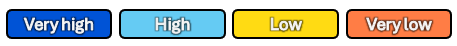


In [8]:
# Visualizing AlphaFold2 predicted protein structure using Py3DMol viewer
# Initialize the viewer
view = py3Dmol.view(width=1200, height=900)

# Add the protein structure from the PDB data
view.addModel(folded_protein, "pdb")

# Set the style and color by B-factor (approximating colors for pLDDT scores)
view.zoomTo()
view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 40, 'max': 100}}})

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Summary

In this workflow, we've demonatrated how to use the AlphaFold2 NIM to generate the predicted 3D structure of a protein from its amino acid sequence.

To learn more about BioNeMo NIMs, visit the [NVIDIA BioNeMo NIMS homepage](https://build.nvidia.com/explore/healthcare).  To see how these NIMs can be integrated into reference workflows, visit [NVIDIA NIM Blueprints](https://build.nvidia.com/nim/blueprints).